# ⭐AIFFEL 대전 1기 Exploration 14. 폐렴을 진단해보자⭐
>  프로젝트 소개: 환자의 X-Ray 사진을 이미지 인식을 통해 이진 분류 실시(폐렴 유무)

***

# 🎯 프로젝트 목표
   * 페렴 데이터 셋 이해, 전처리, 시각화
   * CNN 모델 설계 및 개선 모델 설계
   * 이미지 augmentation 해보기

***

# ✅프로젝트 순서
## 0. 개념 정리
## 1. SetUp
## 2. 데이터 불러오기
## 3. 데이터 전처리
## 4. 데이터 시각화
## 5. CNN 모델링
## 6. 개선 (1) - Data augmentation: 좌우 반전
## 7. 개선 (2) - Data augmentation: 밝기 변경
## 8. 개선 (3) - Dropout 비율 변경(0.2->0.4)
## 9. 개선 (4) - Dropout 비율 변경(dense층 변경)
## 10. 개선 (5) - Dropout 삭제
## 11. 개선 (6) - 좌우반전 + Dropout 삭제
## 12. 개선 (7) - BatchNormalization 삭제
## 13. 개선 (7) - BatchNormalization 삭제 + Dropout비율 변경+좌우반전
## 14. 결과 정리
## 15. 회고
- 15-1. 루브릭 평가  
- 15-2. 회고

***

# 0. 개념 정리
## 1) 의료 영상의 종류
- X-Ray: 전자를 물체에 충돌시킬 때 발생하는 투과력이 강한 복사선(전자기파)  
밀도 낮은 것은 통과(지방, 근육, 천, 종이)  
밀도 높은 것은 통과하지 못함(뼈, 금속)  

- CT:Computed Tomography. 환자를 중심으로 X-Ray를 빠르게 회전하여 3D 이미지를 만들어내는 영상.  
종양 또는 이상을 쉽게 식별하고 위치를 파악할 수 있다. 신체의 단면 이미지를 "Slice"이며 단층 촬영 이미지라고도 한다. 기존의 X-Ray보다 더 자세한 정보를 포함.  

- MRI: Magnetic Resonance Imaging(자기 공명 영상). 신체의 해부학적 과정과 생리적 과정을 보기 위해 사용하는 의료 영상 기술. MRI는 CT, X-RAY와 다르게 방사선을 사용하지 않아서 방사선의 위험성에서는 보다 안전  

## 2) 흉부 X-Ray 영상
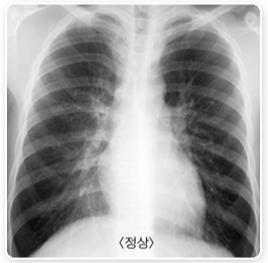
> 출처: [health.cdc.go.kr](http://health.cdc.go.kr/health/Resource/Module/Content/Printok.do?idx=2110&subIdx=4)  
- 갈비뼈: 흰색  
- 폐: 검은색(공기가 차 있음)    
- 어깨 쪽의 지방 및 근육: 연한 회색  

## 3) 데이터 imbalance
- 한 가지 라벨이 너무 많은 상태. 예를 들어 이진 분류('고양이' 또는 '강아지')라고 할 때 학습 데이터셋 안에 '고양이'가 압도적으로 많다면 '강아지' 잘 구별하지 못한 채 학습이 종료될 수 있다.  

**해결방법**  
`weight balancing`:  training set 의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법  

## 4) CNN에서 Dropout와 Batch Normalization
- variance shift를 억제하는 Batch Normalization과 이를 유발시키는 Dropout을 동시에 사용하는 것이 어울리지 않는다는 의견과  
[관련 논문: Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)
- 예외적으로 동시에 사용하는 것이 성능향상에 도움을 주는 경우가 실제로 있어 옹호하는 의견 두 가지 모두 존재함.  
[관련 논문: Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks](https://arxiv.org/pdf/1905.05928.pdf)  


***

# 1. SetUp

#### 데이터 다운받기
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), '1.AIFFEL_Study/Exploration/E14_Diagnose_Pneumonia')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel-dj40/1.AIFFEL_Study/Exploration/E14_Diagnose_Pneumonia


***

# 2. 데이터 불러오기

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames)) # 5216
print(len(test_filenames))  # 624
print(len(val_filenames))   # 16

5216
624
16


***

# 3. 데이터 전처리

### train, val 데이터 합치기, 나누기
- val 데이터가 너무 적기 때문에 train + val 한 후 8:2 비율로 나눈다.

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print('train data 개수는: ',len(train_filenames)) # 4185
print('val data 개수는: ',len(val_filenames))   # 1047
print('test data 개수는: ',len(test_filenames))  # 624

train data 개수는:  4185
val data 개수는:  1047
test data 개수는:  624


### train data 내의 정상 이미지 수와 폐렴 이미지 수 찾기
- train의 경우 라벨별로 개수가 너무 차이 나면 imbalance문제가 생길 수 있다.  

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("train data 내의 정상 이미지 수: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("train data 내의 폐렴 이미지 수: " + str(COUNT_PNEUMONIA))

train data 내의 정상 이미지 수: 1086
train data 내의 폐렴 이미지 수: 3099


### tf.data 인스턴스 생성
- tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있게 해준다.

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


### 라벨 이름확인

In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


### 라벨 데이터 만들어주는 함수
- 현재 라벨 데이터까 따로 없음.

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

### 이미지 사이즈 조정 함수

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

### ❗전체 전처리 함수

In [11]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

### train, validation 데이터 셋 만들기
- **process_path 함수** 이용

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
# 이미지 리사이즈, 라벨이 잘 들어갔는지 확인

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy()) # False: 음성(정상)

Image shape:  (180, 180, 3)
Label:  True


### test 데이터 셋 만들기

In [14]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### train 데이터 셋 변환
- 효율적인 학습을 위해 `shuffle`, `repeat`, `batch`, `prefetch` 이용

In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()
    """
    repeat()를 사용하면 epoch를 진행하면서 여러번 데이터셋을 불러오게 되는데, 
    이때 repeat()를 사용한 데이터셋의 경우 여러번 데이터셋을 사용할 수 있게 해줍니다.
    예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

    """

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)
    """
    prefetch()를 사용하면 학습데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 
    두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.
    """
    
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

***

# 4. 데이터 시각화

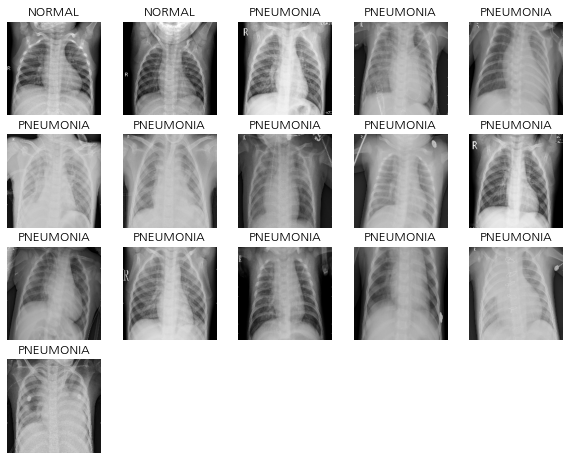

In [16]:
# train에 있는 batch 중 첫 번째 배치를 추출합니다. 
# 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch()함수를 이용해서 결과 사진 보기.

image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

***

# 5. CNN 모델링

### convolution block 정의

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

### dense block 정의

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### CNN 모델 설계

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### imbalance 처리
- `Weight Balancing`사용.  
training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss값을 갖도록 가중치를 부여하는 방법.

In [20]:
# weight_for_0: 'Normal'이미지에 사용할 weight
# weight_for_1: 'Pneumonia'이미지에 사용할 weight

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.68


### 모델 훈련

In [21]:
tf.random.set_seed(2021)

In [22]:
with tf.device('/GPU:0'): # 이미지 훈련을 위해 GPU사용
    model = build_model()

    METRICS = [ # 성과 측정을 위해 metrics으로 'accuracy', 'precision', 'recall' 사용
        'accuracy', 
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 26s 99ms/step - loss: 0.4262 - accuracy: 0.8120 - precision: 0.9462 - recall: 0.7909 - val_loss: 0.5845 - val_accuracy: 0.7481 - val_precision: 0.7481 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 22s 84ms/step - loss: 0.2670 - accuracy: 0.8997 - precision: 0.9698 - recall: 0.8924 - val_loss: 0.6947 - val_accuracy: 0.7481 - val_precision: 0.7481 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 22s 84ms/step - loss: 0.2056 - accuracy: 0.9212 - precision: 0.9726 - recall: 0.9194 - val_loss: 0.2248 - val_accuracy: 0.8971 - val_precision: 0.8802 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 22s 84ms/step - loss: 0.1942 - accuracy: 0.9289 - precision: 0.9742 - recall: 0.9285 - val_loss: 0.1348 - val_accuracy: 0.9433 - val_precision: 0.9423 - val_recall: 0.9846
Epoch 5/25
261/261 [==============================] - 22s 84ms/step - loss: 0.1685 - accuracy: 0

### 결과 확인

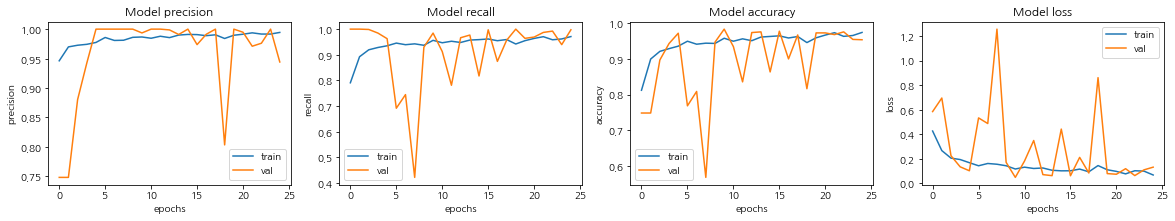

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가(테스트 데이터)
- loss: 1.5170
- accuracy: 0.6939
- precision: 0.6713
- recall: 1.0000

In [25]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 56ms/step - loss: 1.5170 - accuracy: 0.6939 - precision: 0.6713 - recall: 1.0000


***

# 6. 개선 (1) - Data augmentation: 좌우 반전

### 좌우 반전 실행

In [26]:
# train, val data 리셋
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [27]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_flip_left_right(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_flip_left_right = prepare_for_training_flip_left_right(train_ds)
val_ds_flip_left_right = prepare_for_training_flip_left_right(val_ds)

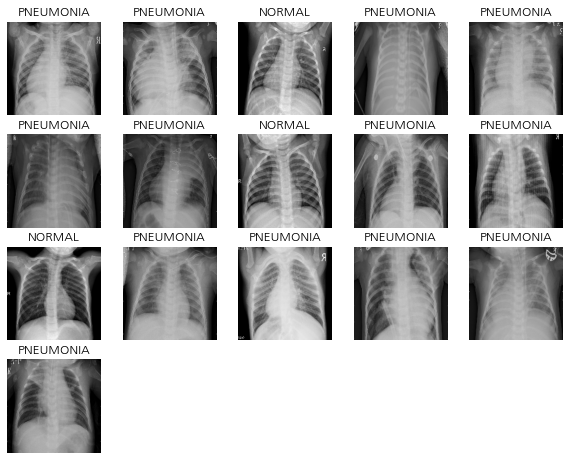

In [28]:
# train에 있는 batch 중 첫 번째 배치를 추출합니다. 
# 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch()함수를 이용해서 결과 사진 보기.

image_batch_flip_left_right, label_batch_flip_left_right = next(iter(train_ds_flip_left_right))
show_batch(image_batch_flip_left_right.numpy(), label_batch_flip_left_right.numpy())

### CNN 모델링

In [29]:
with tf.device('/GPU:0'): # 이미지 훈련을 위해 GPU사용
    model = build_model()

    METRICS = [ # 성과 측정을 위해 metrics으로 'accuracy', 'precision', 'recall' 사용
        'accuracy', 
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [30]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_flip_left_right,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_flip_left_right,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 24s 91ms/step - loss: 0.4252 - accuracy: 0.8015 - precision: 0.9449 - recall: 0.7772 - val_loss: 0.8046 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 23s 88ms/step - loss: 0.2624 - accuracy: 0.9037 - precision: 0.9680 - recall: 0.8997 - val_loss: 1.6471 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 23s 89ms/step - loss: 0.1999 - accuracy: 0.9224 - precision: 0.9753 - recall: 0.9186 - val_loss: 0.2929 - val_accuracy: 0.8769 - val_precision: 0.8595 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 23s 86ms/step - loss: 0.1819 - accuracy: 0.9325 - precision: 0.9772 - recall: 0.9305 - val_loss: 0.1832 - val_accuracy: 0.9356 - val_precision: 0.9986 - val_recall: 0.9152
Epoch 5/25
261/261 [==============================] - 22s 83ms/step - loss: 0.1925 - accuracy: 0

### 결과 확인- 좌우 반전

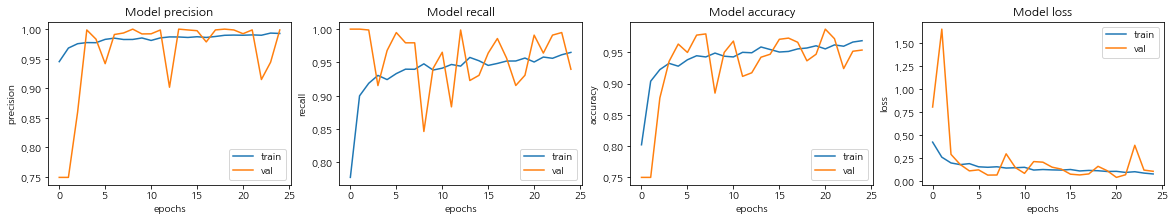

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가(테스트 데이터) - 좌우 반전
- loss: 0.5288
- accuracy: 0.8333
- precision: 0.8095
- recall: 0.9590

In [32]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 57ms/step - loss: 0.5288 - accuracy: 0.8333 - precision: 0.8095 - recall: 0.9590


***

# 7. 개선 (2) - Data augmentation: 밝기 변경

In [33]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [34]:
def augment_bright(image,label):
    image = tf.image.adjust_brightness(image, 0.3) # 이미지 밝기를 변경
    return image,label

def prepare_for_training_bright(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment_bright,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_bright = prepare_for_training_bright(train_ds)
val_ds_bright = prepare_for_training_bright(val_ds)

### 밝기 변경 사진 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

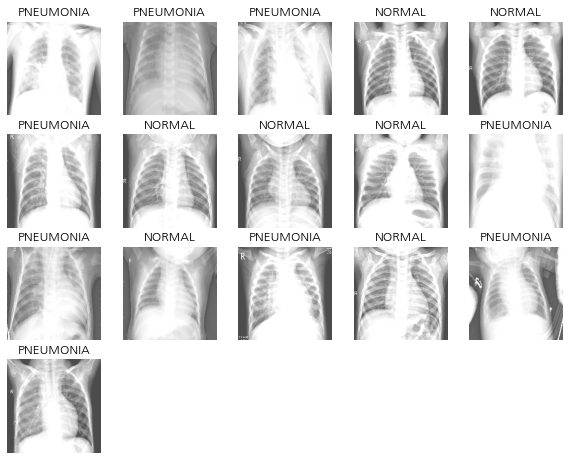

In [35]:
# train에 있는 batch 중 첫 번째 배치를 추출합니다. 
# 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch()함수를 이용해서 결과 사진 보기.

image_batch_bright, label_batch_bright = next(iter(train_ds_bright))
show_batch(image_batch_bright.numpy(), label_batch_bright.numpy())

In [36]:
with tf.device('/GPU:0'): # 이미지 훈련을 위해 GPU사용
    model = build_model()

    METRICS = [ # 성과 측정을 위해 metrics으로 'accuracy', 'precision', 'recall' 사용
        'accuracy', 
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [37]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_bright,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_bright,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 22s 86ms/step - loss: 0.4142 - accuracy: 0.8080 - precision: 0.9494 - recall: 0.7824 - val_loss: 0.7478 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 22s 85ms/step - loss: 0.2588 - accuracy: 0.9001 - precision: 0.9675 - recall: 0.8953 - val_loss: 0.9808 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 22s 84ms/step - loss: 0.1967 - accuracy: 0.9291 - precision: 0.9768 - recall: 0.9262 - val_loss: 0.5900 - val_accuracy: 0.7538 - val_precision: 0.7527 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 22s 83ms/step - loss: 0.1749 - accuracy: 0.9339 - precision: 0.9776 - recall: 0.9321 - val_loss: 0.1123 - val_accuracy: 0.9519 - val_precision: 0.9528 - val_recall: 0.9846
Epoch 5/25
261/261 [==============================] - 22s 83ms/step - loss: 0.1698 - accuracy: 0

### 결과 확인- 밝기 변경

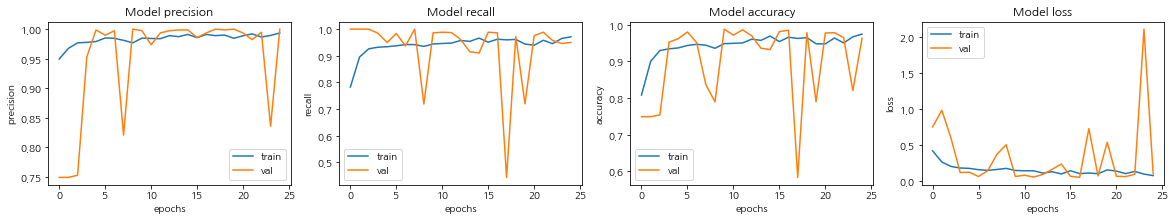

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가(테스트 데이터) - 밝기 변경
- loss: 0.8182
- accuracy: 0.7788
- precision: 0.7414
- recall: 0.9923

In [39]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 56ms/step - loss: 0.8182 - accuracy: 0.7788 - precision: 0.7414 - recall: 0.9923


***

# 8. 개선 (3) - Dropout 비율 변경(0.2->0.4)

In [40]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [41]:
def build_model_dropout_change():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.4), # 기존 0.2 -> 변경 0.4
        
        conv_block(256),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [42]:
with tf.device('/GPU:0'): # 이미지 훈련을 위해 GPU사용
    model = build_model_dropout_change()

    METRICS = [ # 성과 측정을 위해 metrics으로 'accuracy', 'precision', 'recall' 사용
        'accuracy', 
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [43]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 23s 89ms/step - loss: 0.4454 - accuracy: 0.7732 - precision: 0.9416 - recall: 0.7398 - val_loss: 0.5984 - val_accuracy: 0.7481 - val_precision: 0.7481 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 23s 88ms/step - loss: 0.2353 - accuracy: 0.9028 - precision: 0.9692 - recall: 0.8971 - val_loss: 1.0952 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 23s 87ms/step - loss: 0.1870 - accuracy: 0.9248 - precision: 0.9790 - recall: 0.9182 - val_loss: 0.1265 - val_accuracy: 0.9481 - val_precision: 0.9393 - val_recall: 0.9949
Epoch 4/25
261/261 [==============================] - 22s 86ms/step - loss: 0.1833 - accuracy: 0.9286 - precision: 0.9771 - recall: 0.9253 - val_loss: 0.1318 - val_accuracy: 0.9481 - val_precision: 0.9363 - val_recall: 0.9987
Epoch 5/25
261/261 [==============================] - 22s 86ms/step - loss: 0.1764 - accuracy: 0

### 결과 확인-Dropout  변경: 0.2 -> 0.4

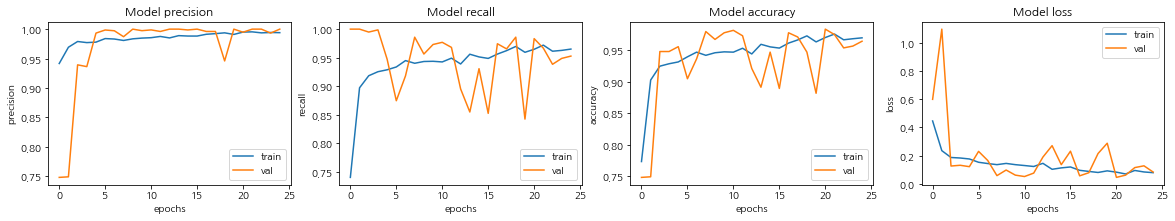

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가(테스트 데이터) - Dropout 변경: 0.2 -> 0.4
- loss: 0.6445
- accuracy: 0.8429
- precision: 0.8106
- recall: 0.9769

In [45]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 61ms/step - loss: 0.6445 - accuracy: 0.8429 - precision: 0.8106 - recall: 0.9769


***

# 9. 개선 (4) - Dropout 비율 변경(dense층 변경)

In [46]:
def build_model_dropout_change():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2), 
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.5), # 0.7 -> 0.5
        dense_block(128, 0.3), # 0.5 -> 0.3
        dense_block(64, 0.1),  # 0.3 -> 0.1
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [47]:
with tf.device('/GPU:0'): # 이미지 훈련을 위해 GPU사용
    model = build_model_dropout_change()

    METRICS = [ # 성과 측정을 위해 metrics으로 'accuracy', 'precision', 'recall' 사용
        'accuracy', 
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [48]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 24s 90ms/step - loss: 0.3042 - accuracy: 0.8678 - precision: 0.9605 - recall: 0.8567 - val_loss: 0.7802 - val_accuracy: 0.7481 - val_precision: 0.7481 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 23s 89ms/step - loss: 0.2057 - accuracy: 0.9217 - precision: 0.9739 - recall: 0.9188 - val_loss: 1.3623 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 23s 88ms/step - loss: 0.1628 - accuracy: 0.9411 - precision: 0.9814 - recall: 0.9383 - val_loss: 0.4811 - val_accuracy: 0.7913 - val_precision: 0.7823 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 23s 87ms/step - loss: 0.1463 - accuracy: 0.9456 - precision: 0.9802 - recall: 0.9456 - val_loss: 0.1907 - val_accuracy: 0.9308 - val_precision: 0.9944 - val_recall: 0.9127
Epoch 5/25
261/261 [==============================] - 22s 85ms/step - loss: 0.1425 - accuracy: 0

### 결과 확인-Dropout  변경: dense층 변경

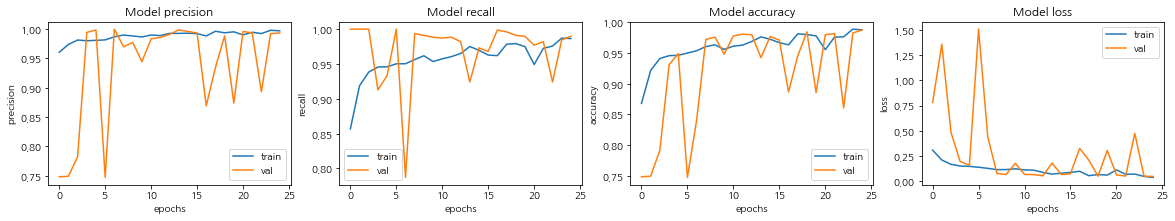

In [49]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가(테스트 데이터) - Dropout층 변경
- loss: 1.1901
- accuracy: 0.8269
- precision: 0.7854
- recall: 0.9949

In [50]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 60ms/step - loss: 1.1901 - accuracy: 0.8269 - precision: 0.7854 - recall: 0.9949


***

# 10. 개선 (5) - Dropout 삭제

In [51]:
def build_model_dropout_delete():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2), 
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
#         dense_block(512, 0.5), 
#         dense_block(128, 0.3), 
#         dense_block(64, 0.1),  
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [52]:
with tf.device('/GPU:0'): # 이미지 훈련을 위해 GPU사용
    model = build_model_dropout_delete()

    METRICS = [ # 성과 측정을 위해 metrics으로 'accuracy', 'precision', 'recall' 사용
        'accuracy', 
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [53]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 23s 90ms/step - loss: 0.2343 - accuracy: 0.8927 - precision: 0.9755 - recall: 0.8771 - val_loss: 0.6080 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 23s 90ms/step - loss: 0.1084 - accuracy: 0.9559 - precision: 0.9853 - recall: 0.9548 - val_loss: 0.4323 - val_accuracy: 0.7529 - val_precision: 0.7517 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 23s 89ms/step - loss: 0.1026 - accuracy: 0.9598 - precision: 0.9873 - recall: 0.9579 - val_loss: 0.1426 - val_accuracy: 0.9606 - val_precision: 0.9533 - val_recall: 0.9961
Epoch 4/25
261/261 [==============================] - 23s 90ms/step - loss: 0.0745 - accuracy: 0.9713 - precision: 0.9911 - recall: 0.9700 - val_loss: 0.0845 - val_accuracy: 0.9663 - val_precision: 0.9592 - val_recall: 0.9974
Epoch 5/25
261/261 [==============================] - 23s 89ms/step - loss: 0.0616 - accuracy: 0

### 결과 확인-Dropout  삭제

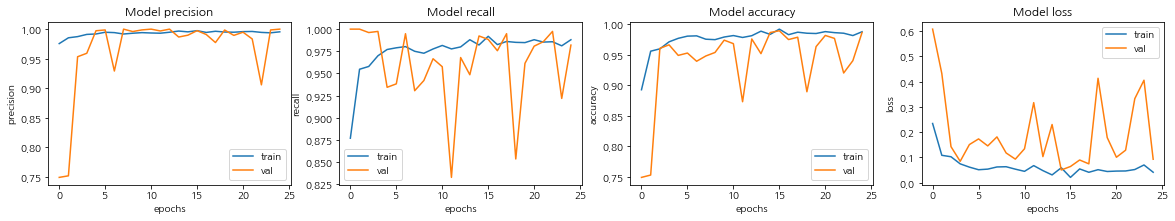

In [54]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가(테스트 데이터) - Dropout 삭제
- loss: 2.4532
- accuracy: 0.7997
- precision: 0.7655
- recall: 0.9795

In [55]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 56ms/step - loss: 2.4532 - accuracy: 0.7997 - precision: 0.7655 - recall: 0.9795


***

# 11. 개선 (6) - 좌우반전 + Dropout 삭제

In [56]:
with tf.device('/GPU:0'): # 이미지 훈련을 위해 GPU사용
    model = build_model_dropout_delete()

    METRICS = [ # 성과 측정을 위해 metrics으로 'accuracy', 'precision', 'recall' 사용
        'accuracy', 
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [60]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_flip_left_right,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=50,
        validation_data=val_ds_flip_left_right,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
261/261 [==============================] - 24s 90ms/step - loss: 0.0394 - accuracy: 0.9856 - precision: 0.9957 - recall: 0.9848 - val_loss: 0.2027 - val_accuracy: 0.9500 - val_precision: 0.9986 - val_recall: 0.9345
Epoch 2/50
261/261 [==============================] - 24s 91ms/step - loss: 0.0611 - accuracy: 0.9792 - precision: 0.9934 - recall: 0.9784 - val_loss: 0.2822 - val_accuracy: 0.9279 - val_precision: 0.9986 - val_recall: 0.9050
Epoch 3/50
261/261 [==============================] - 23s 90ms/step - loss: 0.0808 - accuracy: 0.9765 - precision: 0.9927 - recall: 0.9754 - val_loss: 0.0772 - val_accuracy: 0.9712 - val_precision: 0.9896 - val_recall: 0.9718
Epoch 4/50
261/261 [==============================] - 23s 90ms/step - loss: 0.0414 - accuracy: 0.9847 - precision: 0.9951 - recall: 0.9842 - val_loss: 0.0568 - val_accuracy: 0.9827 - val_precision: 0.9948 - val_recall: 0.9821
Epoch 5/50
261/261 [==============================] - 23s 87ms/step - loss: 0.0414 - accuracy: 0

261/261 [==============================] - 21s 79ms/step - loss: 0.0243 - accuracy: 0.9916 - precision: 0.9971 - recall: 0.9916 - val_loss: 0.0807 - val_accuracy: 0.9788 - val_precision: 0.9974 - val_recall: 0.9744
Epoch 38/50
261/261 [==============================] - 21s 79ms/step - loss: 0.0113 - accuracy: 0.9964 - precision: 0.9990 - recall: 0.9961 - val_loss: 0.0721 - val_accuracy: 0.9827 - val_precision: 0.9810 - val_recall: 0.9961
Epoch 39/50
261/261 [==============================] - 21s 79ms/step - loss: 0.0224 - accuracy: 0.9914 - precision: 0.9977 - recall: 0.9906 - val_loss: 0.0390 - val_accuracy: 0.9846 - val_precision: 0.9847 - val_recall: 0.9949
Epoch 40/50
261/261 [==============================] - 21s 79ms/step - loss: 0.0450 - accuracy: 0.9887 - precision: 0.9961 - recall: 0.9887 - val_loss: 0.0997 - val_accuracy: 0.9808 - val_precision: 0.9786 - val_recall: 0.9961
Epoch 41/50
261/261 [==============================] - 21s 82ms/step - loss: 0.0298 - accuracy: 0.9907 -

### 결과 확인- 좌우 반전 + Dropout 삭제

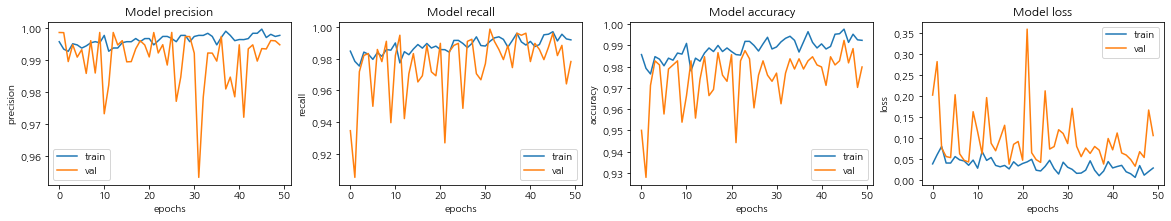

In [61]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가(테스트 데이터) - 좌우 반전 + Dropout 삭제
- loss:3.4386
- accuracy: 0.7708
- precision: 0.7361
- recall: 0.9872

In [62]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 57ms/step - loss: 3.4386 - accuracy: 0.7708 - precision: 0.7361 - recall: 0.9872


***

# 12. 개선 (7) - BatchNormalization 삭제

In [63]:
# conv_block 재정의
def conv_block_bn_delete(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [64]:
# dense_block 재정의
def dense_block_bn_delete(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [65]:
def build_model_batch_delete():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_bn_delete(32),
        conv_block_bn_delete(64),
        
        conv_block_bn_delete(128),
        tf.keras.layers.Dropout(0.2), 
        
        conv_block_bn_delete(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_bn_delete(512, 0.5), 
        dense_block_bn_delete(128, 0.3), 
        dense_block_bn_delete(64, 0.1),  
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [66]:
with tf.device('/GPU:0'): # 이미지 훈련을 위해 GPU사용
    model = build_model_batch_delete()

    METRICS = [ # 성과 측정을 위해 metrics으로 'accuracy', 'precision', 'recall' 사용
        'accuracy', 
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [67]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 23s 88ms/step - loss: 0.3538 - accuracy: 0.8333 - precision: 0.9520 - recall: 0.8159 - val_loss: 0.5774 - val_accuracy: 0.7481 - val_precision: 0.7481 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 21s 82ms/step - loss: 0.1944 - accuracy: 0.9179 - precision: 0.9811 - recall: 0.9066 - val_loss: 0.7514 - val_accuracy: 0.7481 - val_precision: 0.7481 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 22s 85ms/step - loss: 0.1669 - accuracy: 0.9265 - precision: 0.9840 - recall: 0.9157 - val_loss: 0.2033 - val_accuracy: 0.9173 - val_precision: 0.9061 - val_recall: 0.9923
Epoch 4/25
261/261 [==============================] - 22s 84ms/step - loss: 0.1379 - accuracy: 0.9483 - precision: 0.9861 - recall: 0.9434 - val_loss: 0.1482 - val_accuracy: 0.9404 - val_precision: 0.9986 - val_recall: 0.9216
Epoch 5/25
261/261 [==============================] - 22s 85ms/step - loss: 0.1234 - accuracy: 0

### 결과 확인-BatchNoralization  삭제

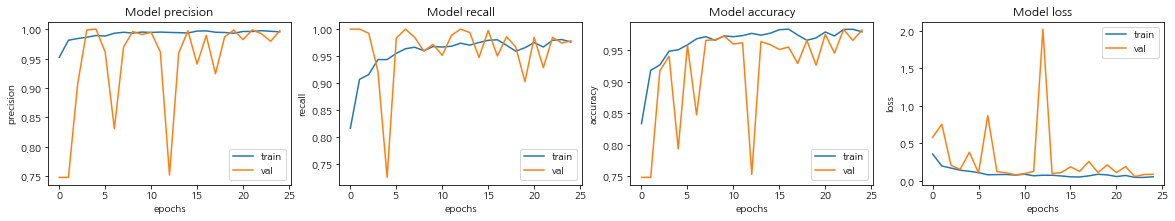

In [68]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가(테스트 데이터) - BatchNoralization 삭제
- loss: 2.0828
- accuracy: 0.8045
- precision: 0.7659
- recall: 0.9897

In [69]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 55ms/step - loss: 2.0828 - accuracy: 0.8045 - precision: 0.7659 - recall: 0.9897


***

# 13. 개선 (7) - BatchNormalization 삭제 + Dropout비율 변경+좌우반전

In [70]:
with tf.device('/GPU:0'): # 이미지 훈련을 위해 GPU사용
    model = build_model_batch_delete()

    METRICS = [ # 성과 측정을 위해 metrics으로 'accuracy', 'precision', 'recall' 사용
        'accuracy', 
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [71]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_flip_left_right,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_flip_left_right,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 23s 90ms/step - loss: 0.3266 - accuracy: 0.8604 - precision: 0.9501 - recall: 0.8564 - val_loss: 0.7240 - val_accuracy: 0.2519 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
261/261 [==============================] - 23s 90ms/step - loss: 0.2188 - accuracy: 0.9092 - precision: 0.9771 - recall: 0.8984 - val_loss: 0.7440 - val_accuracy: 0.7481 - val_precision: 0.7481 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 21s 82ms/step - loss: 0.1750 - accuracy: 0.9294 - precision: 0.9788 - recall: 0.9247 - val_loss: 0.4210 - val_accuracy: 0.8394 - val_precision: 0.9873 - val_recall: 0.7962
Epoch 4/25
261/261 [==============================] - 21s 82ms/step - loss: 0.1580 - accuracy: 0.9389 - precision: 0.9823 - recall: 0.9343 - val_loss: 0.5265 - val_accuracy: 0.7558 - val_precision: 0.9962 - val_recall: 0.6765
Epoch 5/25
261/261 [==============================] - 21s 81ms/step - loss: 0.1508 - acc

### 결과 확인-BatchNoralization  삭제 + Dropout 비율 변경 + 좌우 반전

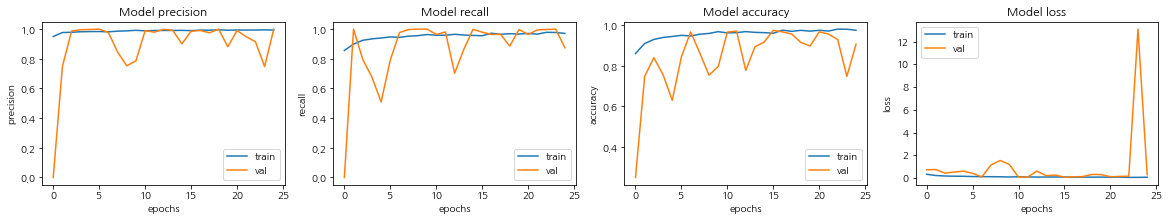

In [72]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가(테스트 데이터) - BatchNoralization 삭제+ Dropout 비율 변경 + 좌우 반전
- loss: 0.6152
- accuracy: 0.8125
- precision: 0.8081
- recall: 0.9179

In [73]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 56ms/step - loss: 0.6152 - accuracy: 0.8125 - precision: 0.8081 - recall: 0.9179


***

# 14. 결과 정리

In [75]:
import pandas as pd

data = {
        'name' : ['default', '좌우 반전', '밝기 변경', 'Dropout 비율 변경', 'dense_block 변경', 'Dropout 삭제',
                '좌우반전+Dropout 삭제', 'BatchNormalization 삭제', 'BatchNormalization 삭제 + Dropout비율 변경+좌우반전'],
       'accuracy' : [0.69, 0.83, 0.77, 0.84, 0.82, 0.79, 0.77, 0.80, 0.81]
       }
df = pd.DataFrame(data)
df

,name,accuracy
0,default,0.69
1,좌우 반전,0.83
2,밝기 변경,0.77
3,Dropout 비율 변경,0.84
4,dense_block 변경,0.82
5,Dropout 삭제,0.79
6,좌우반전+Dropout 삭제,0.77
7,BatchNormalization 삭제,0.80
8,BatchNormalization 삭제 + Dropout비율 변경+좌우반전,0.81


***

# 15. 회고

## 15-1. 루브릭
### 1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
#### (모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.)  
CNN 기반으로 모델링 완성  

### 2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
#### (regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.)  
regularization, augmentation를 활용해 프로젝트를 진행  

### 3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.
#### (Accuracy 기준 85%에 도달하였다.)
7가지 개선 방법을 적용해 기존 accuracy 69%보다 개선한 결과 도출함.  
**Dropout 비율 변경을 통해 85% 가깝게 정확도 개선 성공**

## 15-2. 회고
1. 의료 데이터를 다룰 기회가 적은 데 다루게 되어서 신기함 + 코로나로 인한 의료 분야와 인공지능의 접목이 가속화되고 있는데 경험할 수 있었다.  
2. 또한 의료 데이터의 특성 중 하나인 적은 데이터의 수를 해결하기 위해 augmentation을 실시했다.  
- 여기서 알게된 사실을 정리해보면 아래와 같다.  
&#160;&#160;&#160;&#160; **tf.image.random_flip_left_right(image)**: 선택한 이미지 중 랜덤하게 좌우 반전  [참고링크](https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right)  
&#160;&#160;&#160;&#160; **tf.image.adjust_brightness(image, float)**: 선택한 이미지의 밝기를 조절, float(0~1)가 커질 수록 밝아진다. [참고링크](https://www.tensorflow.org/api_docs/python/tf/image/random_brightness)  
3. 개선 작업 중 `좌우 반전`, `밝기 변경` 두 가지 방법 모두 정확도가 개선되었지만 `좌우 반전`이 좀 더 높은 성능일 보였다. **3회 실행**한 결과 비슷한 결과가 나와서 이번 데이터셋에는 좌우 반전이 크게 영향을 준다고 판단했다. 하지만 내 생각에는 밝기에 따라 좀 더 두드러지는 부분이 있어 더 높은 성능 개선이 있어야 할 거 같은 생각이 든다. (역시 생각대로는 되지 않는 군)  
4. Dropout과 Batch Normalization을 동시에 사용했던 기존 구조와 다르게 둘 중 하나를 삭제해보고 실행했을 때는 비슷한 결과(0.79, 0.80)이 나왔다. 그래도 둘 다 사용하는 기존(0.69)보다는 높아진 것을 확인  
5. 마지막에는 0.8 이상인 3개를 적용해 진행했는데 비약적인 성능 개선이 일어나지는 않았다. (0.81)  
6. 이번 프로젝트는 크게 코드를 만질 일은 없었지만 `augmentation`을 알고 적용해보고 시각화해보는 내용을 얻었다. cv영역에서 중요한 부분이니 나중에 이미지 처리 관련 노드에서 한 번 적용해봐야겠다.